# NNet class in Pytorch

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [97]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` and `use` functions.  These functions must be completed the *PyTorch* way, which is **not** identical to how you completed the network in A2 (though the same principles apply)!

In [98]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh'):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        
        for epoch in range(n_epochs):

            Y = self(X)
            mse = mse_func(T,Y)
            mse.backward()
            
            optimizer.step() 
            optimizer.zero_grad()
            
            self.error_trace = (mse * self.Tstds) + self.Tmeans
            
            if verbose and (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0):
                print(f'Epoch {epoch + 1} Error {self.error_trace[0]:.2f}')
                

    def use(self, X):
 
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()

        # Standardize X
            X0 = (X-self.Xmeans)/self.Xstds
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
            Y0 = self.forward(X0)
            Y = (Y0 * self.Tstds) + self.Tmeans
        
        # Return output Y after detaching from computation graph and converting to numpy
        return Y.detach().numpy()


## Example

In [99]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

Epoch 50 Error 33.36
RMSE 0.867


## Implementation

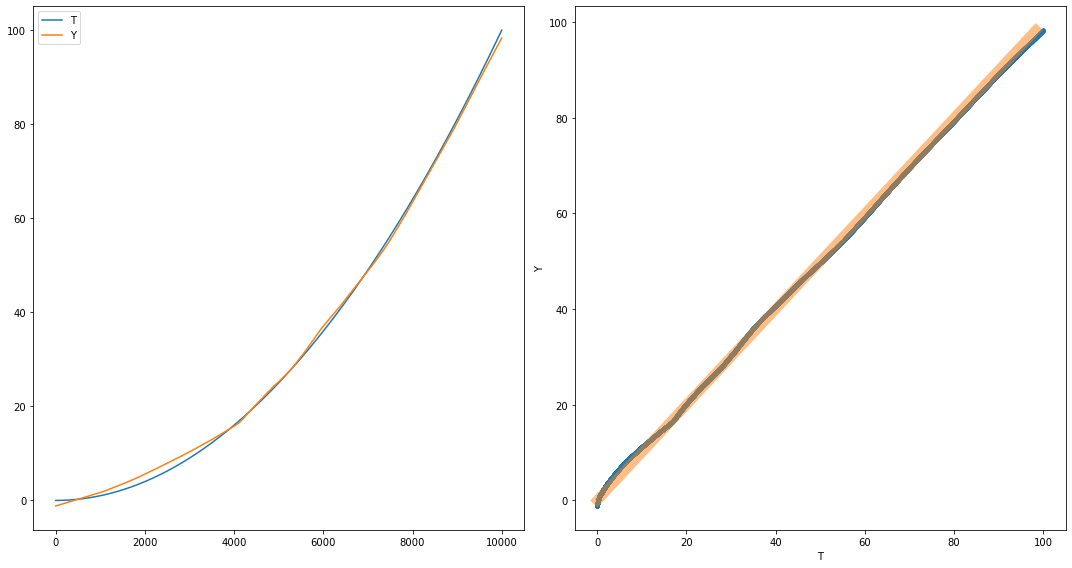

In [100]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

This is complete code for `generate_k_fold_cross_validation_sets`.

In [101]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [102]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [103]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [104]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func):
        for hidden in list_of_n_hiddens:
            for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
                n_outputs = Ttrain.shape[1]
                n_hiddens = [n_folds, n_folds]
                net = NNet(n_inputs, n_hiddens, n_outputs, act_func)
                net.train(Xtrain, Ttrain, n_epochs, learning_rate)
                Y = net.use(X)
            
                trainRMSE += rmse(Y, Ttrain)
                validateRMSE += rmse(Y, Tvalidate)
                testRMSE += rmse(Y, Ttest)
    
        trainRMSEMean = trainRMSE / n_folds
        validateRMSEMean = validateRMSE / n_folds
        testRMSEMean = testRMSE / n_folds
    
        return list_of_n_hiddens, trainRMSEMean, validateRMSEMean, testRMSEMean
                

            
    
    
def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))
        
        

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [105]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described sufficiently.  If you struggle with judging this yourself, you can consider 10 sentences or more of discussion to be sufficient, but 9 perceptive sentences are better than 10 or more sentences of non-analytical fluff.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [106]:
X.shape, T.shape

((6, 2), (6, 1))

In [107]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x2 and 1x5)

Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [ ]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

In [ ]:
plot_results(results)

# Grading and Check-In

You will score 90 points if your `train`, `use`, an `run_k_fold_cross_validation` functions are defined correctly. You can test this grading process yourself by downloading [A3grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A3grader.zip) and extracting `A3grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 90/90.  The remaining 10 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [ ]:
%run -i A3grader.py

Unlike A2, A3 **should be completed individually**.  Name your notebook as `Lastname-A3.ipynb` with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

# Extra Credit

Earn up to 10 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.  You may need to use one of the campus GPU machines for this.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.  You can earn 5 points for doing (1) and another 5 for doing (2).